# Composition

A deep neural network is simply a composition of (parametrized) processing nodes. Composing two nodes $g$ and $f$ gives yet another node $h = f \cdot g$, or $h(x) = f(g(x))$. We can also evaluate two nodes in parallel and express the result as the concatenation of the two outputs, $h(x) = (f(x), g(x))$. As such we can also view a deep nerual network as a single processing node where we have collected all the inputs together (into a single input) and collected all the outputs together (into a single output). This is how deep learning frameworks, such as PyTorch, process data through neural networks.

This tutorial explores the idea of composition using the `ddn.basic` package. Each processing node in the package is assumed to take a single (vector) input and produce a single (vector) output as presented in the ["Deep Declarative Networks: A New Hope"](https://arxiv.org/abs/1909.04866) paper, so we have to merge and split vectors as we process data through the network.


In [1]:
%matplotlib inline

## Example: Matching means

We will develop an example of modifying two vector inputs so that their means match. Our network first computes the mean of each vector, then computes their square difference. Back-propagating to reduce the square difference will modify the vectors such that their means are equal. The network can be visualized as

```
                           .------.
       .------.            |      |
x_1 ---| mean |--- mu_1 ---|      |
       '------'            |      |                     .---------.
                           | diff |--- (mu_1 - mu_2) ---| 1/2 sqr |--- y 
       .------.            |      |                     '---------'
x_2 ---| mean |--- mu_2 ---|      |
       '------'            |      |
                           '------'
```

Viewing the network as a single node we have

```
     .-------------------------------------------------------------------------.
     |                              .------.                                   |
     |          .------.            |      |                                   |
     |   x_1 ---| mean |--- mu_1 ---|      |                                   |
     |  /       '------'            |      |                     .---------.   |
x ---|-<                            | diff |--- (mu_1 - mu_2) ---| 1/2 sqr |---|--- y 
     |  \       .------.            |      |                     '---------'   |
     |   x_2 ---| mean |--- mu_2 ---|      |                                   |
     |          '------'            |      |                                   |
     |                              '------'                                   |
     .-------------------------------------------------------------------------'
```

Note here each of $x_1$ and $x_2$ is an $n$-dimensional vector. So $x = (x_1, x_2) \in \mathbb{R}^{2n}$.

We now develop the code for this example, starting with the upper and lower branches of the network.

In [2]:
import sys
sys.path.append("../")
from ddn.basic.node import *
from ddn.basic.sample_nodes import *
from ddn.basic.robust_nodes import *
from ddn.basic.composition import *

# construct n-dimensional vector inputs
n = 10
x_1 = np.random.randn(n, 1)
x_2 = np.random.randn(n, 1)

x = np.vstack((x_1, x_2))

# create upper and lower branches
upperBranch = ComposedNode(SelectNode(2*n, 0, n-1), RobustAverage(n, 'quadratic'))
lowerBranch = ComposedNode(SelectNode(2*n, n), RobustAverage(n, 'quadratic'))

Here we construct each branch by composing a `SelectNode`, which chooses the appropriate subvector $x_1$ or $x_2$ for the branch, with a `RobustAverage` node, which computes the mean. To make sure things are working so far we evaluate the upper and lower branches, each now expressed as a single composed processing node, and compare their outputs to the mean of $x_1$ and $x_2$, respectively.

In [3]:
mu_1, _ = upperBranch.solve(x)
mu_2, _ = lowerBranch.solve(x)

print("upper branch: {} vs {}".format(mu_1, np.mean(x_1)))
print("lower branch: {} vs {}".format(mu_2, np.mean(x_2)))

upper branch: [0.35571504] vs 0.3557150433275785
lower branch: [-0.2411335] vs -0.2411335017597908


Continuing the example, we now run the upper and lower branches in parallel (to produce $(\mu_1, \mu_2) \in \mathbb{R}^2$) and write a node to take the difference between the two elements of the resulting vector.

In [4]:
# combine the upper and lower branches
meansNode = ParallelNode(upperBranch, lowerBranch)

# node for computing mu_1 - mu_2
class DiffNode(AbstractNode):
    """Computes the difference between elements in a 2-dimensional vector."""
    def __init__(self):
        super().__init__(2, 1)
    
    def solve(self, x):
        assert len(x) == 2
        return x[0] - x[1], None
    
    def gradient(self, x, y=None, ctx=None):
        return np.array([1.0, -1.0])

# now put everything together into a network (super declarative node)
network = ComposedNode(ComposedNode(meansNode, DiffNode()), SquaredErrorNode(1))

# print the initial (half) squared difference between the means
y, _ = network.solve(x)
print(y)

0.17811409288645474


Now let's optimize $x_1$ and $x_2$ so as to make their means equal.

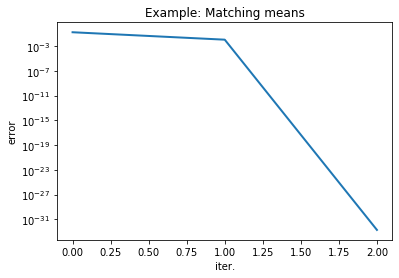

[-0.49003529  1.17948598 -1.68702866 -1.01239936  0.79146087  0.24130503
  0.8052778   0.85165613 -0.98573295  0.87891815]
[ 0.95865934  0.99724414  0.29330379  0.52575762  1.68137593 -0.26575842
 -3.43279949  0.16564688 -1.3222635   0.97174142]
0.05729077078389375
0.057290770783893816


In [5]:
import scipy.optimize as opt
import matplotlib.pyplot as plt

x_init = x.copy()
y_init, _ = network.solve(x_init)
history = [y_init]
result = opt.minimize(lambda xk: network.solve(xk)[0], x_init, args=(), method='L-BFGS-B', jac=lambda xk: network.gradient(xk),
                      options={'maxiter': 1000, 'disp': False},
                      callback=lambda xk: history.append(network.solve(xk)[0]))

# plot results
plt.figure()
plt.semilogy(history, lw=2)
plt.xlabel("iter."); plt.ylabel("error")
plt.title("Example: Matching means")
plt.show()

# print final vectors and their means
x_final = result.x
print(x_final[0:n])
print(x_final[n:])
print(np.mean(x_final[0:n]))
print(np.mean(x_final[n:]))

## Mathematics

To understand composition mathematically, consider the following network,

```
          .---.
      .---| f |---.
     /    '---'    \   .---.
x --<               >--| h |--- y
     \    .---.    /   '---'
      '---| g |---'
          '---'
```

We can write the function as $y = h(f(x), g(x))$. Let's assume that $x$ is an $n$-dimensional vector, $f : \mathbb{R}^n \to \mathbb{R}^p$, $g : \mathbb{R}^m \to \mathbb{R}^q$, and $h : \mathbb{R}^{p+q} \to \mathbb{R}^m$. This implies that the output, $y$, is an $m$-dimensional vector.

We can write the derivative as
$$
\begin{align}
\text{D}y(x) &= \text{D}_{F}h(f, g) \text{D}f(x) + \text{D}_{G}h(f, g) \text{D}g(x) \\
&= \begin{bmatrix} \text{D}_F h & \text{D}_G h \end{bmatrix} \begin{bmatrix} \text{D}f \\ \text{D}g \end{bmatrix}
\end{align}
$$
where the first matrix on the right-hand-side has size $m \times (p + q)$ and the second matrix has size $(p + q) \times n$, giving an $m \times n$ matrix for $\text{D}y(x)$ as expected. Moreover, we can treat the parallel branch as a single node in the graph computing $(f(x), g(x)) \in \mathbb{R}^{p+q}$.

Note that none of this is specific to deep declarative nodes---it is a simple consequence of the rules of differentiation and applies to both declarative and imperative nodes. We can, however, also think about composition of the objective function within the optimization problem defining a declarative node.


## Composed Objectives within Declarative Nodes

Consider the following parametrized optimization problem

$$
\begin{align}
y(x) &= \text{argmin}_{u \in \mathbb{R}} h(f(x, u), g(x, u))
\end{align}
$$

for $x \in \mathbb{R}$. From Proposition 4.3 of the ["Deep Declarative Networks: A New Hope"](https://arxiv.org/abs/1909.04866) paper we have

$$
\begin{align}
\frac{dy}{dx} &= -\left(\frac{\partial^2 h(f(x, y), g(x, y))}{\partial y^2}\right)^{-1} \frac{\partial^2 h(f(x, y), g(x, y))}{\partial x \partial y}
\end{align}
$$

when the various partial derivatives exist. Expanding the derivatives we have

$$
\begin{align}
\frac{\partial h(f(x, y), g(x, y))}{\partial y}
&= \frac{\partial h}{\partial f} \frac{\partial f}{\partial y} + \frac{\partial h}{\partial g} \frac{\partial g}{\partial y}
\\
\frac{\partial^2 h(f(x, y), g(x, y))}{\partial y^2}
&= \frac{\partial^2 h}{\partial y \partial f} \frac{\partial f}{\partial y} +
\frac{\partial h}{\partial f} \frac{\partial^2 f}{\partial y^2} +
\frac{\partial^2 h}{\partial y \partial g} \frac{\partial g}{\partial y} +
\frac{\partial h}{\partial g} \frac{\partial^2 g}{\partial y^2}
\\
&= \begin{bmatrix}
\frac{\partial^2 h}{\partial y \partial f} \\ 
\frac{\partial^2 f}{\partial y^2} \\ 
\frac{\partial^2 h}{\partial y \partial g} \\
\frac{\partial^2 g}{\partial y^2}
\end{bmatrix}^T
\begin{bmatrix}
\frac{\partial f}{\partial y} \\
\frac{\partial h}{\partial f} \\
\frac{\partial g}{\partial y} \\
\frac{\partial h}{\partial g}
\end{bmatrix}
\\
\frac{\partial^2 h(f(x, y), g(x, y))}{\partial x \partial y}
&= \begin{bmatrix}
\frac{\partial^2 h}{\partial x \partial f} \\ 
\frac{\partial^2 f}{\partial x \partial y} \\ 
\frac{\partial^2 h}{\partial x \partial g} \\
\frac{\partial^2 g}{\partial x \partial y}
\end{bmatrix}^T
\begin{bmatrix}
\frac{\partial f}{\partial y} \\
\frac{\partial h}{\partial f} \\
\frac{\partial g}{\partial y} \\
\frac{\partial h}{\partial g}
\end{bmatrix}
\end{align}
$$

As a special case, when $f: (x, u) \mapsto x$ and $g: (x, u) \mapsto u$ we have

$$
\begin{align}
\frac{\partial^2 h(f(x, y), g(x, y))}{\partial y^2}
&= \begin{bmatrix}
\frac{\partial^2 h}{\partial y \partial f} \\ 
0 \\ 
\frac{\partial^2 h}{\partial y \partial g} \\
0
\end{bmatrix}^T
\begin{bmatrix}
0 \\
\frac{\partial h}{\partial f} \\
1 \\
\frac{\partial h}{\partial g}
\end{bmatrix}
&= \frac{\partial^2 h}{\partial y^2}
\\
\frac{\partial^2 h(f(x, y), g(x, y))}{\partial x \partial y}
&= \begin{bmatrix}
\frac{\partial^2 h}{\partial x \partial f} \\ 
0 \\ 
\frac{\partial^2 h}{\partial x \partial g} \\
0
\end{bmatrix}^T
\begin{bmatrix}
0 \\
\frac{\partial h}{\partial f} \\
1 \\
\frac{\partial h}{\partial g}
\end{bmatrix}
&= \frac{\partial^2 h}{\partial x \partial y}
\end{align}
$$

which gives the standard result, as it should.